In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


# **Project Overview**

**In This Project Our Goal is to Build Models That can Predict Category of Crime for Cach Incident.**

In [2]:
# -------------------Important Libraries-------------------#

#Basic Python Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from collections import Counter

#Sklearn Library for Preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder

#Sklearn Library for Model
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.svm import SVC,LinearSVC,NuSVC,SVR

#Sklearn Library for Performance Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Pipeline
from sklearn.pipeline import Pipeline

#Dummy Classifier
from sklearn.dummy import DummyClassifier

#Clustering
from sklearn.cluster import KMeans

#lightgbm 
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [3]:
#Loan Train And Test Data

data = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv') 

print('Training Data Shape', data.shape)
print('Testing Data Shape', test.shape)

Training Data Shape (20000, 22)
Testing Data Shape (5000, 21)


In [4]:
data.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [5]:
# Descriptive Statistics for Training Data
data.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


* Latitude: Values range from 0 to 34.3281. The minimum value of 0 suggests potential data entry errors or missing data that needs to be addressed.
* Longitude: Values range from -118.6634 to 0. The maximum value of 0 indicates potential data entry errors or missing data that needs to be addressed.
* Time_Occurred: The mean is 1352, suggesting most crimes occur in the early afternoon.
* Victim_Age: There are negative values which are likely errors.
* Weapon_Used_Code: Has a mean of 366 and a median of 400, indicating a skew in the distribution.

In [6]:
# Descriptive Statistics for Testing Data
test.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,1847.000000
mean,33.957169,-117.952663,1337.737400,10.736600,1119.879800,1.414000,30.592000,300.858800,364.014077
std,1.986742,6.890957,663.922202,6.051524,605.143645,0.492598,21.897905,212.253742,119.489932
min,0.000000,-118.650300,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.010800,-118.431200,900.000000,6.000000,628.000000,1.000000,14.000000,101.000000,309.000000
50%,34.058000,-118.323200,1430.000000,11.000000,1138.000000,1.000000,31.000000,203.000000,400.000000
75%,34.162250,-118.274600,1900.000000,16.000000,1622.250000,2.000000,46.000000,501.000000,400.000000
max,34.327500,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,957.000000,516.000000


In [7]:
#Null Value in Each Feature
data.isnull().sum()

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

In [8]:
#PercentageWise Null Value in Each Dataset
(data.isnull().sum() / len(data)) * 100

Location                  0.000
Cross_Street             82.760
Latitude                  0.000
Longitude                 0.000
Date_Reported             0.000
Date_Occurred             0.000
Time_Occurred             0.000
Area_ID                   0.000
Area_Name                 0.000
Reporting_District_no     0.000
Part 1-2                  0.000
Modus_Operandi           13.705
Victim_Age                0.000
Victim_Sex               13.120
Victim_Descent           13.120
Premise_Code              0.000
Premise_Description       0.025
Weapon_Used_Code         63.325
Weapon_Description       63.325
Status                    0.000
Status_Description        0.000
Crime_Category            0.000
dtype: float64

* Here ['Cross_Street', 'Weapon_Used_Code', 'Weapon_Description'] Contains More that 50% of Null Values. 
> Cross Street : 82.76%, Weapon_Used_Code and Weapon Description : 63.325%

In [9]:
Numerical = [i for i in data.columns if data[i].dtype == 'float64']
Categorical = [i for i in data.columns if data[i].dtype == 'object']

In [10]:
print('>> Skewness in Data\n')
display(data[Numerical].skew())

>> Skewness in Data



Latitude                -15.852085
Longitude                15.915463
Time_Occurred            -0.474716
Area_ID                  -0.011008
Reporting_District_no    -0.004086
Part 1-2                  0.331902
Victim_Age                0.114913
Premise_Code              0.541494
Weapon_Used_Code         -1.033417
dtype: float64

# **Exploratory Data Analysis (EDA)**

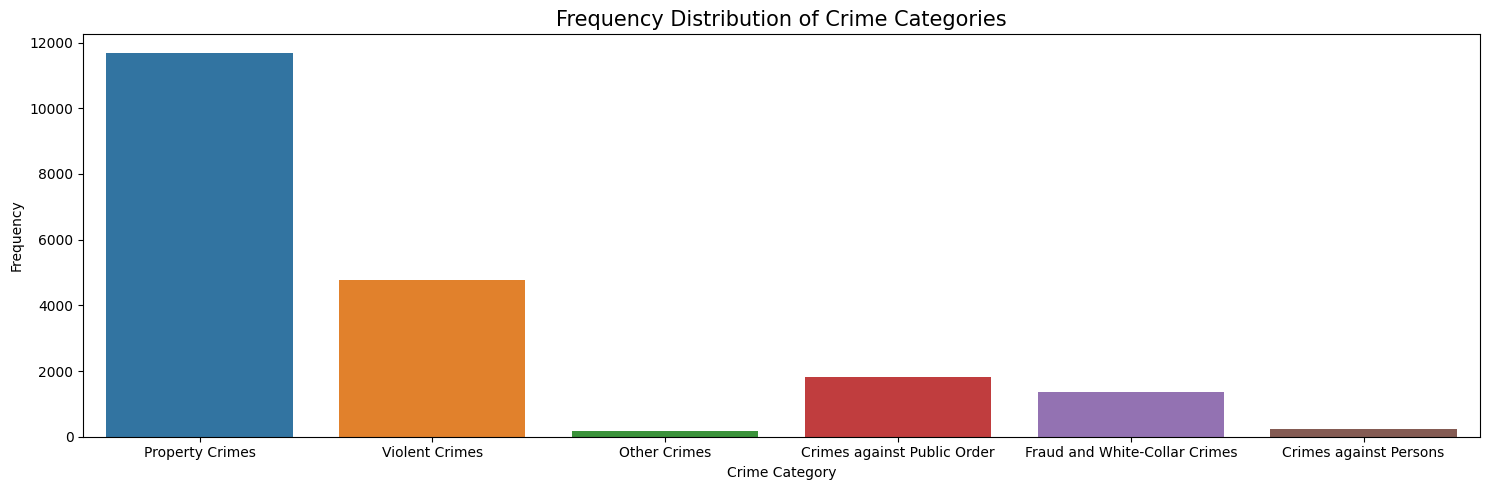

In [11]:
## 1. Frequency Distribution of Target Variable

plt.figure(figsize=(15, 5))  
sns.countplot(x='Crime_Category', data=data)
plt.xlabel('Crime Category')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Crime Categories', fontsize=15)
plt.tight_layout()
plt.show()


Property Crimes                  11666,

Violent Crimes                    4767,

Crimes against Public Order       1808,

Fraud and White-Collar Crimes     1355,

Crimes against Persons             225,

Other Crimes                       179,

> There is a Major Class Imbalance in Target Variable 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

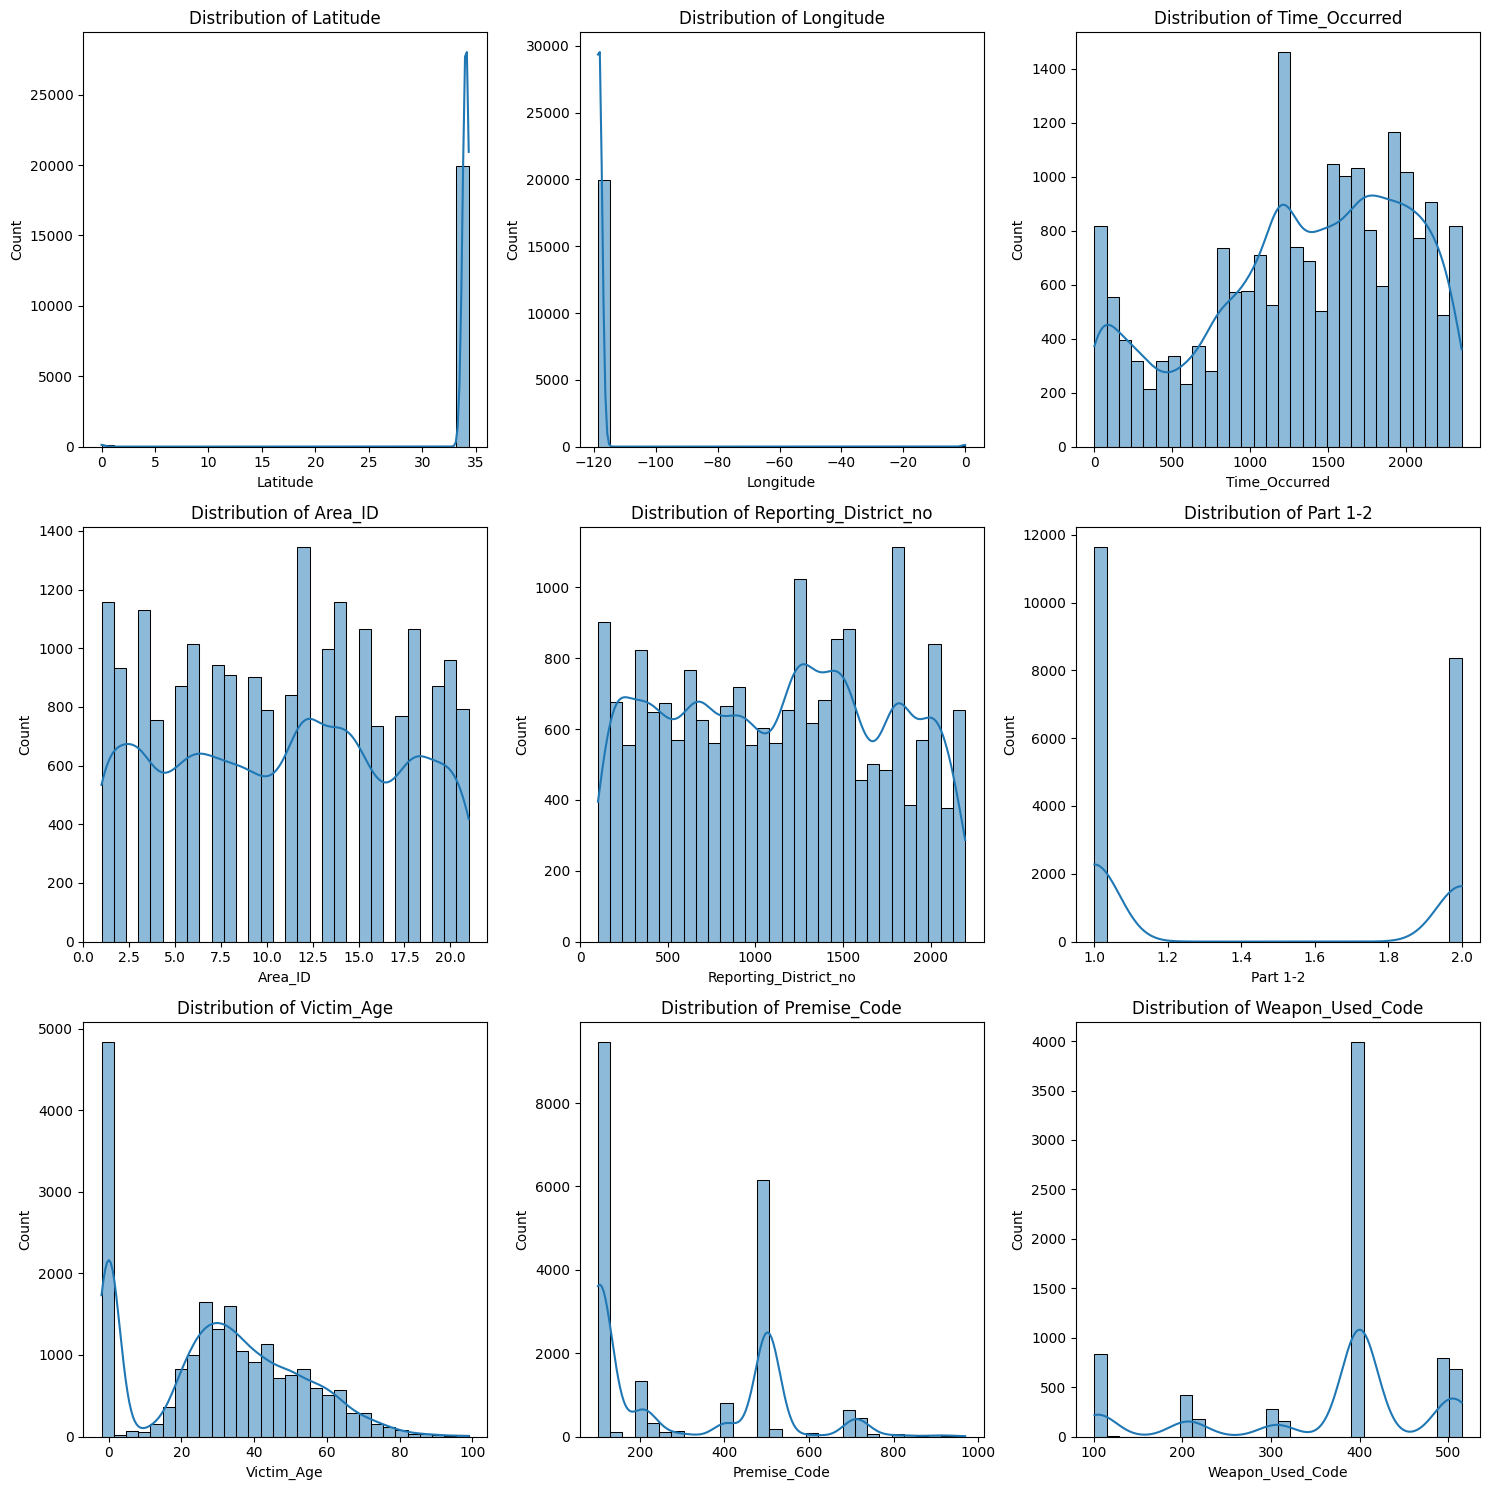

In [12]:
## 2. Distribution of Numerical Feature

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i, feature in enumerate(Numerical):
    sns.histplot(data[feature], bins=30, kde=True, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


* Latitude and Longitude: The distribution of latitude and longitucde highly skewed to the right and left respectively, with most values clustered around a specific range. This indicates that most crimes are occurring within a certain latitude range, possibly suggesting a concentrated geographic area.

* Time_Occurred: The distribution likely shows peaks around certain hours, indicating that most crimes occur in the early afternoon. 

* Victim Age: A significant portion of the Victim_Age data has a value of 0, which indicates both outliers and potential data entry errors.

* Premise_Code: This indicates that certain types of premises are more commonly associated with crimes, while others are less frequent.

* Weapon_Used_Code: The distribution is highly skewed with a median of 400. This suggests that while there are a few very high weapon used codes


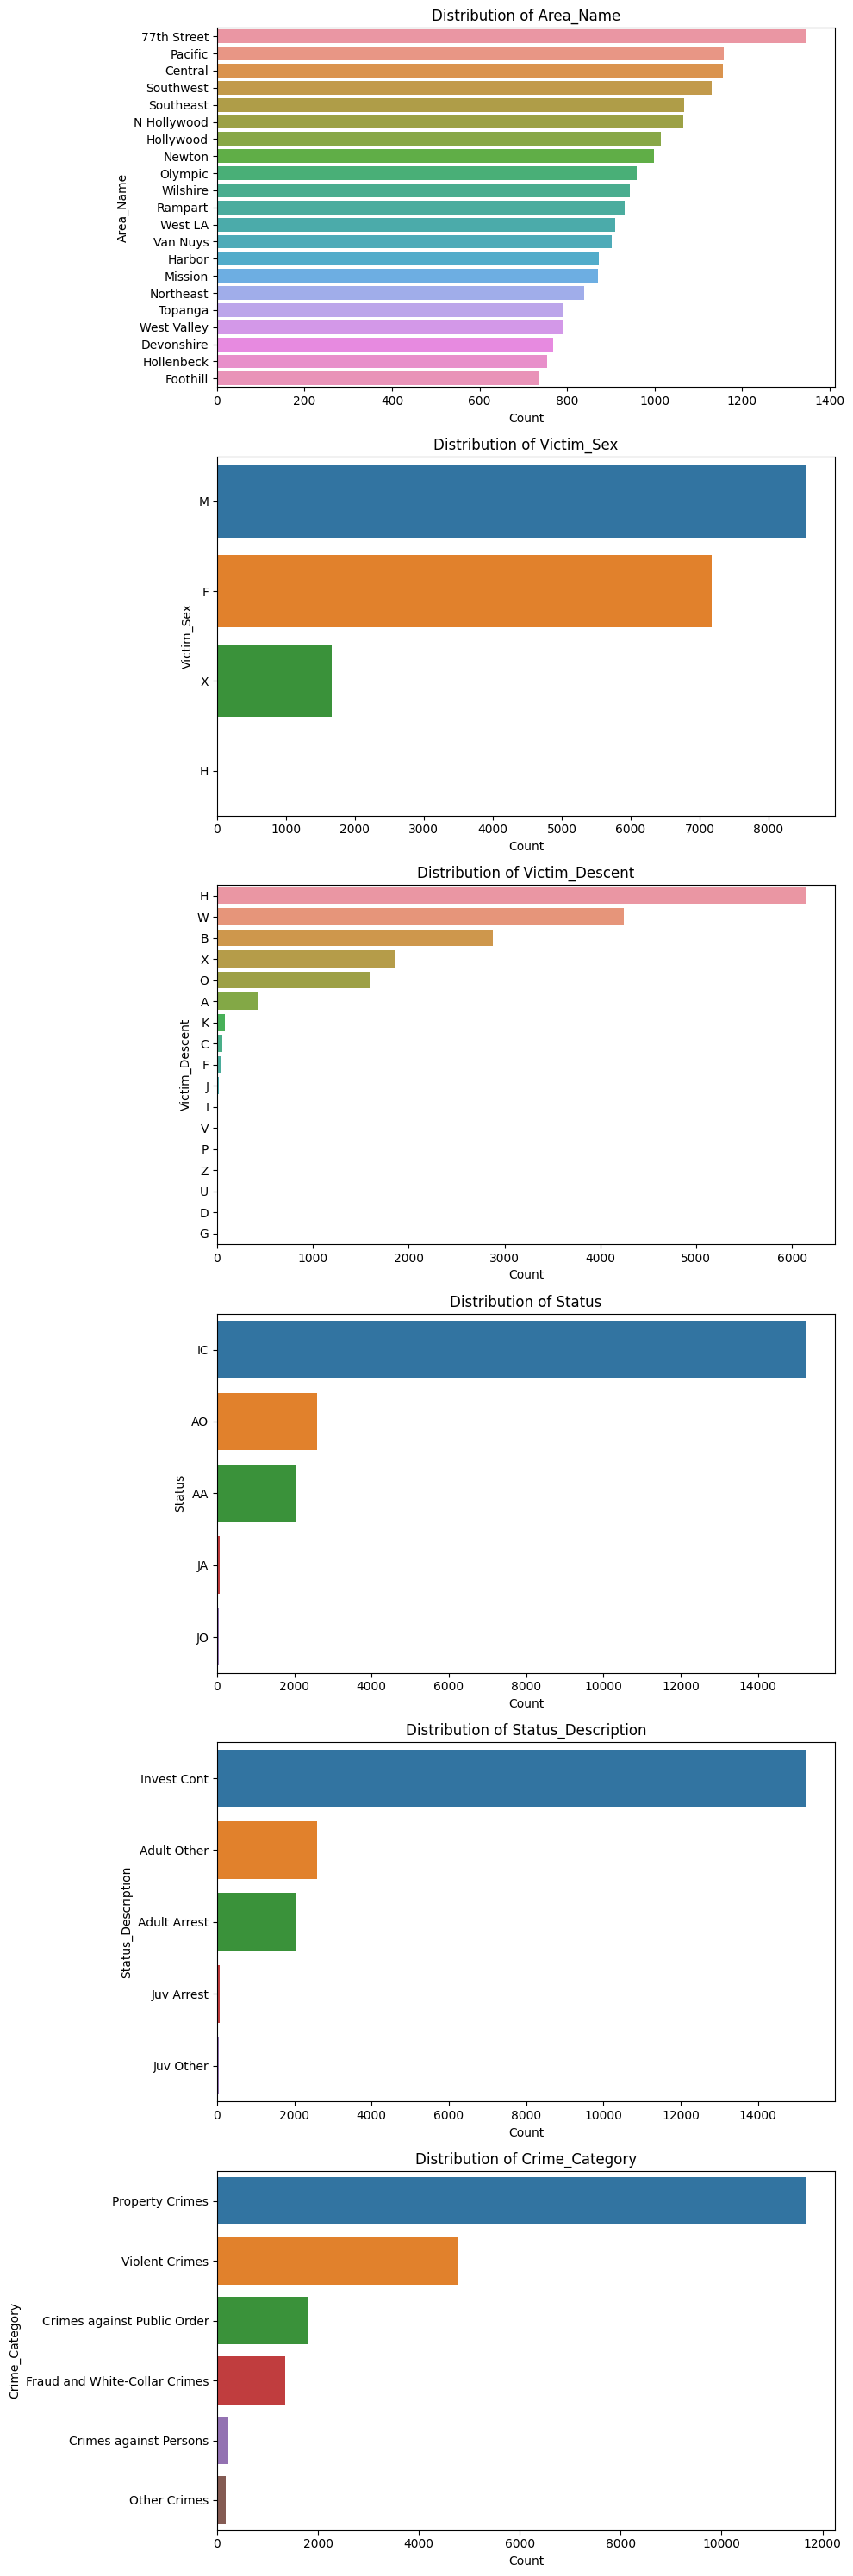

In [13]:
## 3. Frequency Distribution of Categorical Feature

categorical_columns = ['Area_Name', 'Victim_Sex', 'Victim_Descent', 'Status', 'Status_Description', 'Crime_Category']

fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(10, 5 * len(categorical_columns)))

for ax, column in zip(axes, categorical_columns):
    sns.countplot(y=column, data=data, order=data[column].value_counts().index, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel('Count')
    ax.set_ylabel(column)

plt.tight_layout()
plt.show()

* Area Name has 21 unique Categories.

* Victim_Sex: It has a Category like ['X', 'H'], which indicates potential data entry errors.
 
* Victim_Descent: Out of total no of unique categories, 50% of categories has a very lss representation.
 
* Status_Description: It shows that the crime on 'juvenile' is very less. 

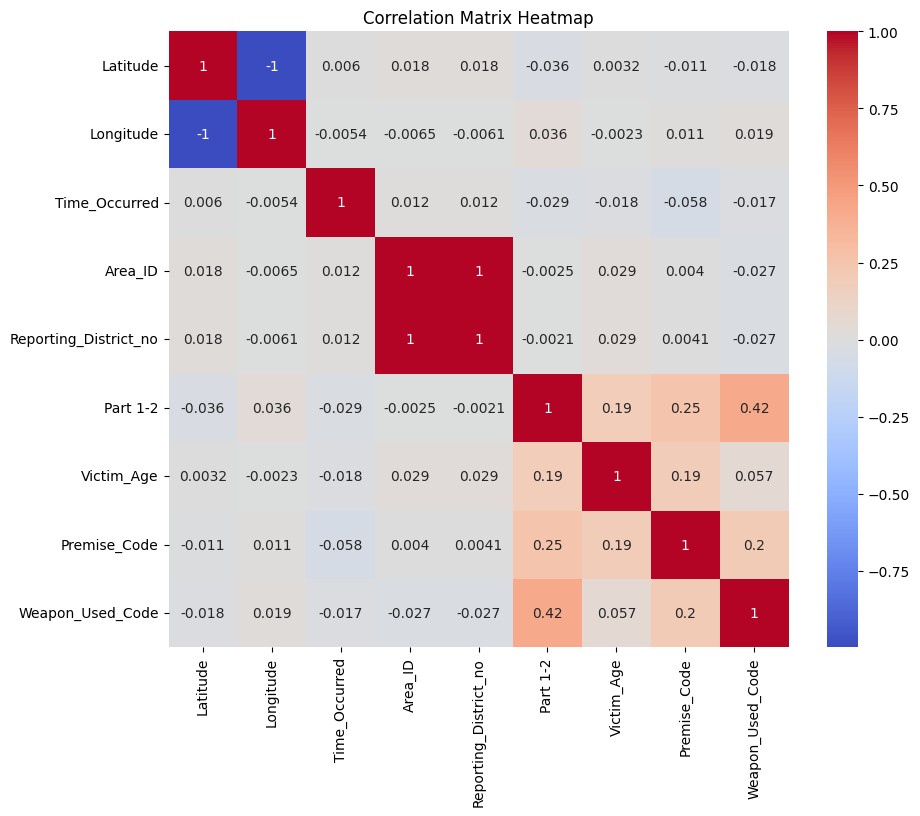

In [14]:
## 4. Correlation Heatmap
corr_matrix = data[Numerical].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


* Strong Negative Correlation between Latitude and Longitude
* Strong Positive Correlation within Geographical feature like Area_ID and Reporting_District_no.
* Every Feature Has Low to No Correlation with Time_Occurred.
* Moderate positive correlations between Part 1-2 and Weapon_Used_Code, indicating that certain crime categories are more likely to involve weapons.

In [15]:
data.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [16]:
#Modus Operandi 

from collections import Counter

split_values = data['Modus_Operandi'].str.split()
flattened_list = []
df = pd.DataFrame(split_values)
df['Modus_Operandi'] = df['Modus_Operandi'].fillna('0')
for sublist in df['Modus_Operandi']:
        for i in sublist:
          flattened_list.append(i)

frequency_counts = Counter(flattened_list)

print(len(frequency_counts))

482


> **Modus_Operandi:** I will create binary features for each unique modus operandi code(total 482). Each binary indicator column for each code will show its presence in each record

min -2.0
max 99.0
mean 30.135
median 31.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Victim_Age', ylabel='Count'>

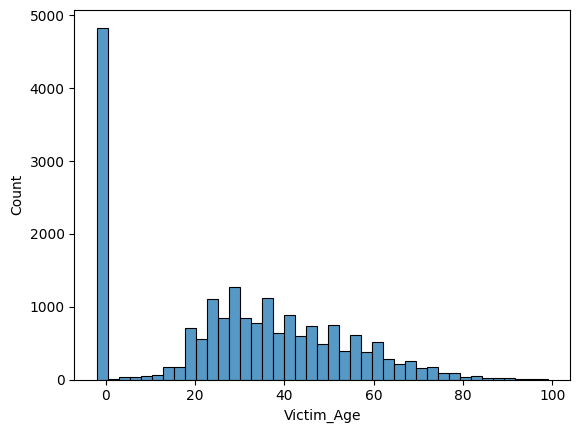

In [17]:
## Victim Age
min = data['Victim_Age'].min()
max = data['Victim_Age'].max()
mean = data['Victim_Age'].mean()
median = data['Victim_Age'].median()

print('min', min)
print('max', max)
print('mean', mean)
print('median', median)
sns.histplot(data['Victim_Age'])

> Here Victim Age has a negative value and 0 are present in data.  I will use median for imputation for age, as it is robust to outliers and skewed data.

<Axes: title={'center': 'Latitude'}>

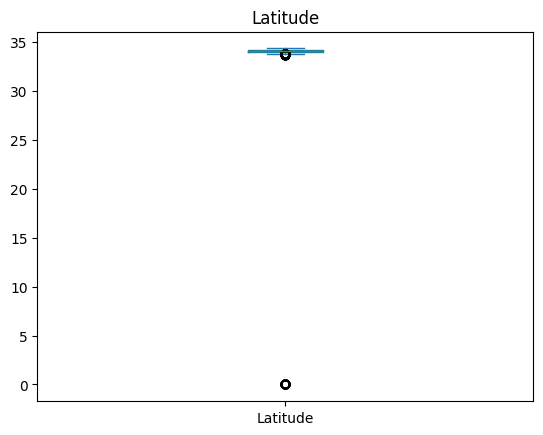

In [18]:
data['Latitude'].plot(kind="box", title="Latitude")

In [19]:
##Time_Occurred
print((data['Time_Occurred'].min(), data['Time_Occurred'].max()))

(1.0, 2359.0)


**Here Time_Occurred Value is Like**
> 1.0 --> 12:00,  
>2359.0 --> 23:59 --> 11:59pm

In [20]:
##Area_ID

print(len(data['Area_ID'].unique()))

21


* 'Area_ID' is an categorical feature feature which contians a numerical value as label. There are 21 unique code same as 'Area_Name'

This Feature are same, both as same no of unique category, Just like Categorical Feature with its Encoded Version

* 'Area_ID' <--> 'Area_Name'
* 'Premise_Code'  <-----> 'Premise_Description'
* 'Weapon_Used_Code' <-----> 'Weapon_Description'
* 'Status' <-----> 'Status_Description'

In [21]:
##'Area_ID' <--> 'Area_Name'
grouped_data = data.groupby('Area_ID')['Area_Name'].unique().reset_index()

grouped_data

,Area_ID,Area_Name
0,1.0,[Central]
1,2.0,[Rampart]
2,3.0,[Southwest]
3,4.0,[Hollenbeck]
4,5.0,[Harbor]
5,6.0,[Hollywood]
6,7.0,[Wilshire]
7,8.0,[West LA]
8,9.0,[Van Nuys]
9,10.0,[West Valley]


In [22]:
##'Status' <--> 'Status_Description'
grouped_data = data.groupby('Status')['Status_Description'].unique().reset_index()

grouped_data

,Status,Status_Description
0,AA,[Adult Arrest]
1,AO,[Adult Other]
2,IC,[Invest Cont]
3,JA,[Juv Arrest]
4,JO,[Juv Other]


# **Feature Engineering/Extrection**


**1. Date and Time Feature Engineering:**

> I have converted 'Date_Reported' and 'Date_Occurred' columns from string format to datetime format. And Then I extracted new features from these datetime columns, including year, month, day, day of the week, and a boolean indicating if the date falls on a weekend.

**2. Time Difference Calculation:**

> I have calculated the time difference in hours between 'Date_Reported' and 'Date_Occurred' and added this as a new feature (Time_Difference).
Time Period Conversion:

**3. Time_Occurred:**

> As observed that many crimes happened during afternoon time. By This Insights I converted the Time_Occurred feature (originally representing time in HHMM format) to categorical time periods (Morning, Afternoon, Evening, Night) based on the hour of the day.

**4. Location:**

> I applied KMeans clustering to the Latitude and Longitude features to create a new feature (Location_Cluster) indicating clusters of geographic locations.

**5. Handling Modus Operandi Feature**

> Converted the Modus_Operandi column from a string representation of lists to actual lists of integers.
Created binary features for each unique modus operandi code present in the dataset, resulting in a binary indicator column for each code to show its presence in each record(Just like One Hot Encoding of Each Unique Modus_Operandi).
for example:



                    '0416 0945 1822 0400 0417 0344' -----> [0416, 0945, 1822, 0400, 0417, 0344] ----> '0416' as Unique Feature



**6. Dropping Unused Columns:**

> Dropped original date columns (Date_Reported and Date_Occurred), location-related columns (Location and Cross_Street), and the processed Modus_Operandi column to avoid redundancy and reduce dimensionality.



# **Feature Preprocessing Strategy**

**Numerical Variables**:
> Latitude, Longitude, Time_Occurred, Area_ID, Reporting_District_no, Part 1-2, Victim_Age, Premise_Code, Weapon_Used_Code

**Categorical Variables**
> Location, Cross_Street, Date_Reported, Date_Occurred, Area_Name, Modus_Operandi, Victim_Sex, Victim_Descent, Premise_Description, Weapon_Description, Status, Status_Description, Crime_Category

**Imputation Strategy for Null Values**

> Cross_Street: This categorical variable has many missing values(around 82%). Impute with a new category like "Unknown".

> Modus_Operandi: Categorical with significant missing values. Impute with "Unknown".

> Victim_Sex, Victim_Descent: Impute missing values with the mode.

> Premise_Description: Impute missing values with the most frequent value.

> Weapon_Used_Code, Weapon_Description: Impute with 0 for the code and "None" for the description.

**Categorical Encoding**

> For linear models, I will use One-Hot Encoding for categorical variables.

> For ensemble models, I will use Label Encoding for categorical variables.

> For Modus_Operandi, I will transforms the 'Modus_Operandi' column into multiple binary columns indicating the presence or absence of each unique value. 

In [23]:
#---------------------- Feature Engineering and Preprocessing----------------------#


# Feature Engineering: Date and Time features
def extract_date_features(df, column):
    df[column] = pd.to_datetime(df[column], format='%m/%d/%Y %I:%M:%S %p')
    df[f'{column}_year'] = df[column].dt.year
    df[f'{column}_month'] = df[column].dt.month
    df[f'{column}_day'] = df[column].dt.day
    df[f'{column}_dayofweek'] = df[column].dt.dayofweek
    df[f'{column}_is_weekend'] = df[column].dt.dayofweek >= 5
    return df

def convert_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

def preprocess(df):
    # Handling missing values
    df.fillna({
        'Weapon_Used_Code': 0,
        'Weapon_Description': 'None',
        'Cross_Street': 'None',
        'Victim_Age': df['Victim_Age'].median(),
        'Victim_Sex': 'Unknown',
        'Victim_Descent': 'Unknown'}, inplace=True)

    df = extract_date_features(df, 'Date_Reported')
    df = extract_date_features(df, 'Date_Occurred')
    
    
    #Handling Victim Age
    df['Victim_Age'] =df['Victim_Age'].replace([-1,-2],0)
    imputer = SimpleImputer(missing_values=0, strategy='constant', fill_value= df['Victim_Age'].median())
    df['Victim_Age'] = imputer.fit_transform(np.array(df['Victim_Age']).reshape(-1,1))

    # Calculate time difference
    df['Time_Difference'] = (df['Date_Reported'] - df['Date_Occurred']).dt.total_seconds() / 3600.0

    # Convert Time_Occurred to categorical period
    df['Time_Period'] = df['Time_Occurred'].apply(lambda x: convert_time_period(int(x // 100)))

    # Encode categorical variables
    label_encoders = {}
    categorical_columns = ['Location', 'Cross_Street', 'Area_Name', 'Victim_Sex', 'Victim_Descent', 'Premise_Description', 'Weapon_Description', 'Status', 'Time_Period']

    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # KMeans clustering for Latitude and Longitude
    kmeans = KMeans(n_clusters=10, random_state=0)
    df['Location_Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])

    # Drop original date columns, Modus_Operandi, and other unused columns
    columns_to_drop = ['Date_Reported', 'Date_Occurred', 'Location', 'Cross_Street', 'Status_Description']
    df.drop(columns=columns_to_drop, inplace=True)

    if 'Crime_Category' in df.columns:
      le = LabelEncoder()
      df['Crime_Category'] = le.fit_transform(df['Crime_Category'])

    return df


In [24]:
##Preprocessing of Modus_Operandi

#It will find all the unique Modus_Operandi and Create Binary features with unique opernation code as index. 
#From Both Train and Test Dataset.
def MO_list(df):

    split_values =  df['Modus_Operandi'].str.split()
    data = pd.DataFrame(split_values)
    df['Modus_Operandi'] = data['Modus_Operandi']
    df['Modus_Operandi'] = df['Modus_Operandi'].fillna('0')

    return df

def MO_train_test(train, test):

    train = MO_list(train)
    test = MO_list(test)

    flattened_list = []
    for sublist in train['Modus_Operandi']:
            for i in sublist:
              flattened_list.append(i)

    for sublist in test['Modus_Operandi']:
            for i in sublist:
              flattened_list.append(i)

    frequency_counts = Counter(flattened_list) #List of each unique Modus_Operandi with Total no. of Occurence in Feature

    for code in frequency_counts.keys():
        train[f'Modus_{code}'] = train['Modus_Operandi'].apply(lambda x: 1 if code in x else 0)
        test[f'Modus_{code}'] = test['Modus_Operandi'].apply(lambda x: 1 if code in x else 0)

    # Drop the original 'Modus_Operandi' column
    train = train.drop('Modus_Operandi', axis=1)
    test = test.drop('Modus_Operandi', axis=1)

    return train, test

In [25]:
## Load the Dataset
train = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

#Preprocess
train_data = preprocess(train)
test_data = preprocess(test)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
data1, data2 = MO_train_test(train_data, test_data)

/tmp/ipykernel_18/2561762461.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f'Modus_{code}'] = train['Modus_Operandi'].apply(lambda x: 1 if code in x else 0)
/tmp/ipykernel_18/2561762461.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f'Modus_{code}'] = train['Modus_Operandi'].apply(lambda x: 1 if code in x else 0)
/tmp/ipykernel_18/2561762461.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

# **BaseLine: Dummy Classifier**

In [27]:
# Create a dummy classifier

train_df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
X = train_df.drop('Crime_Category', axis = 'columns')
y = train_df['Crime_Category']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

# Fit the classifier on the training data
model = DummyClassifier(strategy = 'most_frequent')
model.fit(X_train, y_train)
dummy_pred = model.predict(X_val)

#Performance Matrix
metrics = pd.DataFrame(columns = ['Accuracy', 'F1_Score'])
metrics.loc['Dummy Classifier'] = [accuracy_score(y_val, dummy_pred), f1_score(y_val, dummy_pred, average = 'macro')]
print(classification_report(y_val, dummy_pred))
print("\nAccuracy (Validation Data) : {}%".format(round(metrics.loc[metrics.index[-1]].Accuracy*100, 3)))
print("Macro F1-Score (Validation Data) : {}".format(round(metrics.loc[metrics.index[-1]].F1_Score, 3)))


                               precision    recall  f1-score   support

       Crimes against Persons       0.00      0.00      0.00        66
  Crimes against Public Order       0.00      0.00      0.00       598
Fraud and White-Collar Crimes       0.00      0.00      0.00       461
                 Other Crimes       0.00      0.00      0.00        65
              Property Crimes       0.58      1.00      0.73      3808
               Violent Crimes       0.00      0.00      0.00      1602

                     accuracy                           0.58      6600
                    macro avg       0.10      0.17      0.12      6600
                 weighted avg       0.33      0.58      0.42      6600


Accuracy (Validation Data) : 57.697%
Macro F1-Score (Validation Data) : 0.122


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* The model is highly biased towards predicting Property Crimes, as high recall (1.00) and relatively good F1-score (0.73) for this class.
* The model completely fails to identify other crime categories, with precision, recall, and F1-scores all at 0.00 for those categories.
* The macro average F1-score of 0.12 indicates that the model performs poorly when considering all classes equally.
* The weighted average F1-score of 0.42 suggests that the model's performance is dominated by its ability to predict the most frequent class (Property Crimes).

# **Model 1 : Logistic Regression**

In [28]:
#Basic Logistic Regression
# Split the data into features and target variable
X = data1.drop(columns=['Crime_Category'])
y = data1['Crime_Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.7461
Testing Accuracy: 0.7488


In [29]:
## 1.1. Logistic Regression With Different Imputing Strategy

# Split the data into training and testing sets
X = data.drop(columns=['Crime_Category'], axis=1)
y = data['Crime_Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# NOTE: Removed 'Crime_Category' from Categorical list
Numerical = [i for i in data.columns if data[i].dtype == 'float64']
Categorical = [i for i in data.columns if data[i].dtype == 'object' and i != 'Crime_Category'] 

# Define numeric and categorical features
numeric_features = Numerical
categorical_features = Categorical

# Define separate preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the pipeline including preprocessing and the Logistic Regression model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print('='*25 + f' Model : Logistic Regression ' + '='*25 + '\n')
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

========================= Model : Logistic Regression =========================

Training Accuracy: 0.9858
Testing Accuracy: 0.8738


In [30]:
# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: ({cv_scores.mean():.4f} ± {cv_scores.std():.4f})")

Cross-Validation Accuracy: (0.8687 ± 0.0032)


In [31]:
#Classification Report
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred)
print(classification_report(y_test, y_pred))

                               precision    recall  f1-score   support

       Crimes against Persons       0.33      0.09      0.15        32
  Crimes against Public Order       0.76      0.66      0.70       374
Fraud and White-Collar Crimes       0.78      0.85      0.81       267
                 Other Crimes       0.00      0.00      0.00        35
              Property Crimes       0.94      0.93      0.93      2303
               Violent Crimes       0.81      0.89      0.85       989

                     accuracy                           0.87      4000
                    macro avg       0.60      0.57      0.57      4000
                 weighted avg       0.87      0.87      0.87      4000



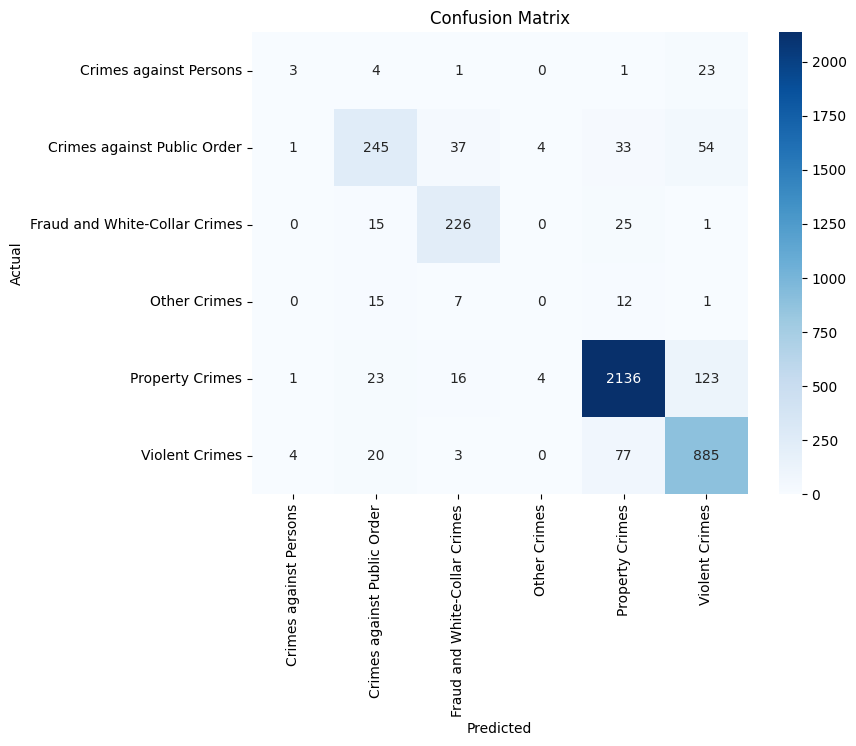

In [32]:
labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Model 2 : K-Nearest Neighbour (KNN)**

In [33]:
'''from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

X = data1.drop(columns=['Crime_Category'], axis=1)
y = data1['Crime_Category']

# Encode the target variable 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) 

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42) # Use encoded y

# Initialize KNN classifier
knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=20))])

knn.fit(X_train, y_train)

# Predict on test data
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
'''

'from sklearn.model_selection import GridSearchCV\nfrom sklearn.neighbors import KNeighborsClassifier\n\nX = data1.drop(columns=[\'Crime_Category\'], axis=1)\ny = data1[\'Crime_Category\']\n\n# Encode the target variable \nlabel_encoder = LabelEncoder()\ny_encoded = label_encoder.fit_transform(y) \n\n# Split the data into train and test sets\nX_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42) # Use encoded y\n\n# Initialize KNN classifier\nknn = Pipeline([\n    (\'scaler\', StandardScaler()),\n    (\'knn\', KNeighborsClassifier(n_neighbors=20))])\n\nknn.fit(X_train, y_train)\n\n# Predict on test data\ny_pred = knn.predict(X_test)\n\n# Evaluate the model\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Accuracy: {accuracy:.2f}")\n'

In [34]:
'''## Classification Report and Confusion Matrix for KNNClassifier

print('='*25 + f' Model : KNNClassifier ' + '='*25 + '\n')
print(classification_report(y_test, y_pred))

y_test=pd.DataFrame(y_test)
labels = sorted(y_test[0].unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
 
#plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()'''

"## Classification Report and Confusion Matrix for KNNClassifier\n\nprint('='*25 + f' Model : KNNClassifier ' + '='*25 + '\n')\nprint(classification_report(y_test, y_pred))\n\ny_test=pd.DataFrame(y_test)\nlabels = sorted(y_test[0].unique())\ncm = confusion_matrix(y_test, y_pred, labels=labels)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)\n \n#plot the Confusion Matrix\nplt.figure(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)\nplt.xlabel('Predicted')\nplt.ylabel('Actual')\nplt.title('Confusion Matrix')\nplt.show()"

# **Model-4 : Support Vector Machine (SVM)**

In [35]:
'''from sklearn.svm import SVC

X = data1.drop(columns=['Crime_Category'])
y = data1['Crime_Category']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the SVM classifier
svm_classifier = SVC()

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Predict on test data
y_pred = svm_classifier.predict(X_test)

print('='*25 + f' Model : SVM ' + '='*25 + '\n')

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {accuracy:.4f}")
'''

'from sklearn.svm import SVC\n\nX = data1.drop(columns=[\'Crime_Category\'])\ny = data1[\'Crime_Category\']\n\n# Standardize features\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\n\n# Split the data into train and test sets\nX_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)\n\n# Initialize the SVM classifier\nsvm_classifier = SVC()\n\n# Train the SVM classifier\nsvm_classifier.fit(X_train, y_train)\n\n# Predict on test data\ny_pred = svm_classifier.predict(X_test)\n\nprint(\'=\'*25 + f\' Model : SVM \' + \'=\'*25 + \'\n\')\n\n# Evaluate the model\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Accuracy: {accuracy:.2f}")\n\nprint(f"Training Accuracy: {train_accuracy:.4f}")\nprint(f"Testing Accuracy: {accuracy:.4f}")\n'

In [36]:
'''## Classification Report and Confusion Matrix for Support Vector Classifier

print('='*25 + f' Model : SVM ' + '='*25 + '\n')
print(classification_report(y_test, y_pred))

labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()'''

"## Classification Report and Confusion Matrix for Support Vector Classifier\n\nprint('='*25 + f' Model : SVM ' + '='*25 + '\n')\nprint(classification_report(y_test, y_pred))\n\nlabels = sorted(y_test.unique())\ncm = confusion_matrix(y_test, y_pred, labels=labels)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)\n    \nplt.figure(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)\nplt.xlabel('Predicted')\nplt.ylabel('Actual')\nplt.title('Confusion Matrix')\nplt.show()"

# **Model 5 : Random Forest**

In [37]:
'''## Random Forest Classifier && Finetuning Hyperameter

X = data1.drop(columns=['Crime_Category'])
y = data1['Crime_Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}

# Initialize the RandomForestClassifier, GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Predict on the test set with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy after Hypertuning: {accuracy}")'''


'## Random Forest Classifier && Finetuning Hyperameter\n\nX = data1.drop(columns=[\'Crime_Category\'])\ny = data1[\'Crime_Category\']\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Define the parameter grid for GridSearchCV\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [10, 20, 30]\n}\n\n# Initialize the RandomForestClassifier, GridSearchCV\nrf = RandomForestClassifier(random_state=42)\ngrid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring=\'accuracy\')\ngrid_search.fit(X_train, y_train)\n\n# Get the best parameters and the best model\nbest_params = grid_search.best_params_\nbest_model = grid_search.best_estimator_\n\nprint(f"Best Parameters: {best_params}")\n\n# Predict on the test set with the best model\ny_pred = best_model.predict(X_test)\n\n# Evaluate the model\'s accuracy\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Model Accuracy after Hypertuning: 

In [38]:
'''## Classification Report and Confusion Matrix for Random Forest Classifier

print(classification_report(y_test, y_pred))

labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()'''

"## Classification Report and Confusion Matrix for Random Forest Classifier\n\nprint(classification_report(y_test, y_pred))\n\nlabels = sorted(y_test.unique())\ncm = confusion_matrix(y_test, y_pred, labels=labels)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)\n    \nplt.figure(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)\nplt.xlabel('Predicted')\nplt.ylabel('Actual')\nplt.title('Confusion Matrix')\nplt.show()"

# **Model 6 :  GradientBoostingClassifier**

In [39]:
'''## Gradient Boosting Classifier && Finetuning Hyperameter

X = data1.drop(columns=['Crime_Category'])
y = data1['Crime_Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100,200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6]
}

# Initialize the GradientBoostingClassifier, GridSearchCV
gbc = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Predict on the test set with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model's accuracy
print('='*25 + f' Model : GradientBoostingClassifier ' + '='*25 + '\n')
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy after Hypertuning: {accuracy}")'''


'## Gradient Boosting Classifier && Finetuning Hyperameter\n\nX = data1.drop(columns=[\'Crime_Category\'])\ny = data1[\'Crime_Category\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Define the parameter grid for GridSearchCV\nparam_grid = {\n    \'n_estimators\': [100,200],\n    \'learning_rate\': [0.01, 0.1],\n    \'max_depth\': [3, 6]\n}\n\n# Initialize the GradientBoostingClassifier, GridSearchCV\ngbc = GradientBoostingClassifier(random_state=42)\n\ngrid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring=\'accuracy\')\ngrid_search.fit(X_train, y_train)\n\n# Get the best parameters and the best model\nbest_params = grid_search.best_params_\nbest_model = grid_search.best_estimator_\n\nprint(f"Best Parameters: {best_params}")\n\n# Predict on the test set with the best model\ny_pred = best_model.predict(X_test)\n\n# Evaluate the model\'s accuracy\nprint(\'=\'*25 + f\' Model : GradientBoost

In [40]:
'''## Classification Report and Confusion Matrix for Gradient Boosting Classifier

print('='*25 + f' Model : Gradient Boosting Classifier ' + '='*25 + '\n')
print(classification_report(y_test, y_pred))

labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()'''

"## Classification Report and Confusion Matrix for Gradient Boosting Classifier\n\nprint('='*25 + f' Model : Gradient Boosting Classifier ' + '='*25 + '\n')\nprint(classification_report(y_test, y_pred))\n\nlabels = sorted(y_test.unique())\ncm = confusion_matrix(y_test, y_pred, labels=labels)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)\n    \nplt.figure(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)\nplt.xlabel('Predicted')\nplt.ylabel('Actual')\nplt.title('Confusion Matrix')\nplt.show()"

# **Cross-Validation of Different Ensemble learning algorithm**

In [41]:
'''# Define the models
models = [
    ('Random Forest', RandomForestClassifier(random_state=42, n_estimators=200, max_depth=20)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42, n_estimators=200, learning_rate=0.1)),
    ('AdaBoost', AdaBoostClassifier(random_state=42, n_estimators=100)),
    ('Bagging', BaggingClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(random_state=42, learning_rate = 0.1, max_depth = 6, n_estimators = 200))
]

#split the data into train and test split.
X = data1.drop(columns=['Crime_Category'])
y = data1['Crime_Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store results for comparison
results = []

for name, model in models:
    print(f'Model: {name}')
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f'Cross-Validation Accuracy: {cv_scores.mean()}')

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    
    
    print(f'Training Accuracy: {train_accuracy}')
    print(f'Testing Accuracy: {test_accuracy}')
    print(f'Classification Report:\n{classification_report(y_test, y_pred)}')
    print('-'*30)

    # Save results
    results.append({
        'model': name,
        'cross_val_accuracy': cv_scores.mean(),
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'f1_score': f1
    })'''


"# Define the models\nmodels = [\n    ('Random Forest', RandomForestClassifier(random_state=42, n_estimators=200, max_depth=20)),\n    ('Gradient Boosting', GradientBoostingClassifier(random_state=42, n_estimators=200, learning_rate=0.1)),\n    ('AdaBoost', AdaBoostClassifier(random_state=42, n_estimators=100)),\n    ('Bagging', BaggingClassifier(n_estimators=100, random_state=42)),\n    ('xgb', XGBClassifier(random_state=42, learning_rate = 0.1, max_depth = 6, n_estimators = 200))\n]\n\n#split the data into train and test split.\nX = data1.drop(columns=['Crime_Category'])\ny = data1['Crime_Category']\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Store results for comparison\nresults = []\n\nfor name, model in models:\n    print(f'Model: {name}')\n    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')\n    print(f'Cross-Validation Accuracy: {cv_scores.mean()}')\n\n    # Train the model\n    model.fit(X_train,

# **Models Comparision**

In [42]:
'''model_performance = {
    'model': ['Random Forest', 'Gradient Boosting', 'AdaBoost', 'Bagging', 'Extra Trees'],
    'Cross-Validation Accuracy': [0.9293, 0.9553, 0.8051, 0.9498, 0.9563],
    'Training Accuracy': [0.9798, 0.9789, 0.8517, 1.0000, 0.9942],
    'Testing Accuracy': [0.9332, 0.9553, 0.8500, 0.9525, 0.9605],
    'F1 Score (weighted)': [0.92, 0.95, 0.85, 0.95, 0.96]
}

df_performance = pd.DataFrame(model_performance)
df_performance
'''

"model_performance = {\n    'model': ['Random Forest', 'Gradient Boosting', 'AdaBoost', 'Bagging', 'Extra Trees'],\n    'Cross-Validation Accuracy': [0.9293, 0.9553, 0.8051, 0.9498, 0.9563],\n    'Training Accuracy': [0.9798, 0.9789, 0.8517, 1.0000, 0.9942],\n    'Testing Accuracy': [0.9332, 0.9553, 0.8500, 0.9525, 0.9605],\n    'F1 Score (weighted)': [0.92, 0.95, 0.85, 0.95, 0.96]\n}\n\ndf_performance = pd.DataFrame(model_performance)\ndf_performance\n"

In [43]:
'''##Model Comparison Based on F1 Score and Accuracy.

results_df = pd.DataFrame(results)

# Plot the comparison
plt.figure(figsize=(12, 6))
results_df.set_index('model')[['test_accuracy', 'f1_score']].plot(kind='bar')
plt.title('Model Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()
'''

"##Model Comparison Based on F1 Score and Accuracy.\n\nresults_df = pd.DataFrame(results)\n\n# Plot the comparison\nplt.figure(figsize=(12, 6))\nresults_df.set_index('model')[['test_accuracy', 'f1_score']].plot(kind='bar')\nplt.title('Model Comparison')\nplt.ylabel('Score')\nplt.ylim(0, 1)\nplt.xticks(rotation=45)\nplt.show()\n"

**Analysis and Insights**

>Extra Trees and Gradient Boosting are the best-performing models overall, with high cross-validation and testing accuracies, along with strong F1 scores.

>Bagging shows a perfect training accuracy (1.0), which suggests overfitting.

>Random Forest is a strong performer but slightly behind the top models.

>AdaBoost lags in performance and might need further tuning or a different approach to improve.

>Extra Trees, Gradient Boosting, and Bagging have high weighted F1 scores, indicating they handle the class imbalances well and provide a good trade-off between precision and recall.


**Performance across different classes**

>**class 0:** Most models struggle with precision and recall for this class due to its rarity in the dataset. 

>**class 1 and class 2:** All models perform reasonably well for these classes, achieving high precision, recall, and F1 scores.

>**class 3:** It is challenging class for all models. Bagging and Random Forest show slightly better results compared to others

>**class 4:** All models perform exceptionally well, with very high precision, recall, and F1 scores due to the large number of instances of this class in the dataset.

>**class 5:** The performance is high across all models, with Extra Trees and Gradient Boosting slightly leading in performance metrics.

**Improvement Strategies**

>Further Tuning: Additional hyperparameter tuning could help improve models, especially AdaBoost.

>Ensemble Methods: Combining the best models (Gradient Boosting and Extra Trees) using ensemble techniques could give even better performance.

>Class Imbalance Handling: Implementing techniques like SMOTE, class weighting, or undersampling could improve the performance for underrepresented classes (Class 0 and Class 3).

# **Hyperparameter Tuning of XGBClassifier**

In [44]:
'''from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6]
}

# Initialize the XGBClassifier and GridSearchCV
xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Predict on the test set with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy after Hypertuning: {accuracy}")
'''

'from xgboost import XGBClassifier\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Define the parameter grid for GridSearchCV\nparam_grid = {\n    \'n_estimators\': [100, 200],\n    \'learning_rate\': [0.01, 0.1],\n    \'max_depth\': [3, 6]\n}\n\n# Initialize the XGBClassifier and GridSearchCV\nxgb = XGBClassifier(random_state=42)\ngrid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring=\'accuracy\')\ngrid_search.fit(X_train, y_train)\n\n# Get the best parameters and the best model\nbest_params = grid_search.best_params_\nbest_model = grid_search.best_estimator_\n\nprint(f"Best Parameters: {best_params}")\n\n# Predict on the test set with the best model\ny_pred = best_model.predict(X_test)\n\n# Evaluate the model\'s accuracy\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Model Accuracy after Hypertuning: {accuracy}")\n'

In [45]:
'''## Classification Report and Confusion Matrix for XGBC Classifier

print('='*25 + f' Model : XGBClassifier' + '='*25 + '\n')
print(classification_report(y_test, y_pred))

labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
'''

"## Classification Report and Confusion Matrix for XGBC Classifier\n\nprint('='*25 + f' Model : XGBClassifier' + '='*25 + '\n')\nprint(classification_report(y_test, y_pred))\n\nlabels = sorted(y_test.unique())\ncm = confusion_matrix(y_test, y_pred, labels=labels)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)\n    \nplt.figure(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)\nplt.xlabel('Predicted')\nplt.ylabel('Actual')\nplt.title('Confusion Matrix')\nplt.show()\n"

# **LightGBM Classifier**

In [46]:
'''X = data1.drop(columns=['Crime_Category'])
y = data1['Crime_Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Initiate LGBMClassifier
lgb = LGBMClassifier(random_state=42,boosting_type='dart')
lgb.fit(X_train, y_train)

# Predict on the test set
y_pred = lgb.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")
'''

'X = data1.drop(columns=[\'Crime_Category\'])\ny = data1[\'Crime_Category\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n#Initiate LGBMClassifier\nlgb = LGBMClassifier(random_state=42,boosting_type=\'dart\')\nlgb.fit(X_train, y_train)\n\n# Predict on the test set\ny_pred = lgb.predict(X_test)\n\n# Evaluate the model\'s accuracy\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Model Accuracy: {accuracy}")\n'

In [47]:
'''## Classification Report and Confusion Matrix for LightBGM Classifier

print('='*25 + f' Model : LightGBM Classifier' + '='*25 + '\n')
print(classification_report(y_test, y_pred))

labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
'''

"## Classification Report and Confusion Matrix for LightBGM Classifier\n\nprint('='*25 + f' Model : LightGBM Classifier' + '='*25 + '\n')\nprint(classification_report(y_test, y_pred))\n\nlabels = sorted(y_test.unique())\ncm = confusion_matrix(y_test, y_pred, labels=labels)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)\n    \nplt.figure(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)\nplt.xlabel('Predicted')\nplt.ylabel('Actual')\nplt.title('Confusion Matrix')\nplt.show()\n"

In [48]:
'''# Make predictions
predictions = lgb.predict(data2)

submission_df = pd.DataFrame({
    'ID': range(1, len(predictions) + 1),  # Using index as ID
    'Crime_Category': predictions
})

submission_df.to_csv('submission.csv', index=False)
'''

"# Make predictions\npredictions = lgb.predict(data2)\n\nsubmission_df = pd.DataFrame({\n    'ID': range(1, len(predictions) + 1),  # Using index as ID\n    'Crime_Category': predictions\n})\n\nsubmission_df.to_csv('submission.csv', index=False)\n"

In [49]:
# Feature Engineering: Date and Time features
def extract_date_features(df, column):
    df[column] = pd.to_datetime(df[column], format='%m/%d/%Y %I:%M:%S %p')
    df[f'{column}_year'] = df[column].dt.year
    df[f'{column}_month'] = df[column].dt.month
    df[f'{column}_day'] = df[column].dt.day
    df[f'{column}_dayofweek'] = df[column].dt.dayofweek
    df[f'{column}_is_weekend'] = df[column].dt.dayofweek >= 5
    return df

def convert_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

def preprocess(df):
    # Handling missing values
    df.fillna({
        'Weapon_Used_Code': 0,
        'Weapon_Description': 'None',
        'Cross_Street': 'None',
        'Victim_Age': df['Victim_Age'].median(),
        'Victim_Sex': 'Unknown',
        'Victim_Descent': 'Unknown'}, inplace=True)

    df = extract_date_features(df, 'Date_Reported')
    df = extract_date_features(df, 'Date_Occurred')

    # Calculate time difference
    df['Time_Difference'] = (df['Date_Reported'] - df['Date_Occurred']).dt.total_seconds() / 3600.0

    # Convert Time_Occurred to categorical period
    df['Time_Period'] = df['Time_Occurred'].apply(lambda x: convert_time_period(int(x // 100)))

    '''# Encode categorical variables
    label_encoders = {}
    categorical_columns = ['Area_Name', 'Victim_Sex', 'Victim_Descent', 'Premise_Description', 'Weapon_Description', 'Status', 'Time_Period']

    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le'''

    # KMeans clustering for Latitude and Longitude
    kmeans = KMeans(n_clusters=10, random_state=0)
    df['Location_Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])

    # Drop original date columns, Modus_Operandi, and other unused columns
    columns_to_drop = ['Date_Reported', 'Date_Occurred', 'Location', 'Cross_Street', 'Status_Description']
    df.drop(columns=columns_to_drop, inplace=True)
    

    return df

In [50]:
from sklearn.preprocessing import OneHotEncoder
def one_hot_encode(train, test, categorical_columns):
    # Encode categorical variables using OneHotEncoder
    one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    train_encoded = one_hot_encoder.fit_transform(train[categorical_columns])
    test_encoded = one_hot_encoder.transform(test[categorical_columns])

    # Convert encoded arrays to DataFrames
    train_encoded_df = pd.DataFrame(train_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_columns))
    test_encoded_df = pd.DataFrame(test_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_columns))

    # Ensure feature names are valid for LightGBM by replacing special characters
    train_encoded_df.columns = train_encoded_df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
    test_encoded_df.columns = test_encoded_df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

    # Drop original categorical columns
    train = train.drop(columns=categorical_columns).reset_index(drop=True)
    test = test.drop(columns=categorical_columns).reset_index(drop=True)

    # Concatenate encoded columns with original DataFrame
    train = pd.concat([train, train_encoded_df], axis=1)
    test = pd.concat([test, test_encoded_df], axis=1)

    return train, test

In [51]:
def MO_list(df):

    split_values =  df['Modus_Operandi'].str.split()
    data = pd.DataFrame(split_values)
    df['Modus_Operandi'] = data['Modus_Operandi']
    df['Modus_Operandi'] = df['Modus_Operandi'].fillna('0')

    return df

def MO_train_test(train, test):

    train = MO_list(train)
    test = MO_list(test)

    flattened_list = []
    for sublist in train['Modus_Operandi']:
            for i in sublist:
              flattened_list.append(i)

    for sublist in test['Modus_Operandi']:
            for i in sublist:
              flattened_list.append(i)

    frequency_counts = Counter(flattened_list)

    for code in frequency_counts.keys():
        train[f'Modus_{code}'] = train['Modus_Operandi'].apply(lambda x: 1 if code in x else 0)
        test[f'Modus_{code}'] = test['Modus_Operandi'].apply(lambda x: 1 if code in x else 0)
    
    # Drop the original 'Modus_Operandi' column
    train = train.drop('Modus_Operandi', axis=1)
    test = test.drop('Modus_Operandi', axis=1)

    return train, test

In [52]:
train = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

train_data = preprocess(train)
test_data = preprocess(test)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [53]:
data1, data2 = MO_train_test(train_data, test_data)

/tmp/ipykernel_18/588253575.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f'Modus_{code}'] = train['Modus_Operandi'].apply(lambda x: 1 if code in x else 0)
/tmp/ipykernel_18/588253575.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[f'Modus_{code}'] = test['Modus_Operandi'].apply(lambda x: 1 if code in x else 0)
/tmp/ipykernel_18/588253575.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

In [54]:
# List of categorical columns to be one-hot encoded
categorical_columns = ['Area_Name', 'Victim_Sex', 'Victim_Descent', 'Premise_Description', 'Weapon_Description', 'Status', 'Time_Period']

# One-hot encode training and test data
data1, data2 = one_hot_encode(data1, data2, categorical_columns)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [55]:
# Split the data into features and target variable
X = data1.drop(columns=['Crime_Category'])
y = data1['Crime_Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb1 = LGBMClassifier(random_state=42, learning_rate=0.1, n_estimators=150, num_leaves=31, verbose=-1)
lgb1.fit(X_train, y_train)

# Predict on the test set
y_pred = lgb1.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.961


In [56]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Split the data into features and target variable
X_train = data1.drop(columns=['Crime_Category'])
y_train = data1['Crime_Category']

lgb = LGBMClassifier(random_state=42, learning_rate=0.1, n_estimators=150, num_leaves=31, verbose=-1)
lgb.fit(X_train, y_train)

LGBMClassifier(n_estimators=150, random_state=42, verbose=-1)

In [57]:
# Make predictions
predictions = lgb.predict(data2)

submission_df = pd.DataFrame({
    'ID': range(1, len(predictions) + 1),  # Using index as ID
    'Crime_Category': predictions
})

submission_df.to_csv('submission.csv', index=False)